<a href="https://colab.research.google.com/github/meetprakhar/TALKFiles/blob/main/Model-Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip Python.zip

Archive:  Python.zip
   creating: Python/
  inflating: Python/sample_angle_data.csv  
  inflating: Python/plot_angle_data.py  
  inflating: Python/requirements.txt  
  inflating: Python/filter_data.py   
   creating: Python/data/
  inflating: Python/data/DataCircle1.csv  
  inflating: Python/data/DataSquare1_new.csv  
  inflating: Python/functions-test-run.ipynb  
  inflating: Python/utils.py         
   creating: Python/__pycache__/
  inflating: Python/__pycache__/plot_angle_data.cpython-37.pyc  
  inflating: Python/__pycache__/filter_data.cpython-37.pyc  
   creating: Python/local/
  inflating: Python/local/model.py   


In [ ]:
%cd Python

/content/Python


In [ ]:
%env CUDA_LAUNCH_BLOCKING=1
import torch
from torch import nn
import torch.nn.functional as f
from torch.optim.optimizer import Optimizer
import numpy as np
import pandas as pd
from torchsummary import summary
import random
import os
import glob
from scipy.signal import savgol_filter as sgolayfilt
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder as ohe

def calc_delta(arr):
    del_arr = np.zeros_like(arr)
    del_arr[1:] = np.array(
        list([arr[i] - arr[i-1] for i in range(1, len(arr))]))
    return del_arr


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


# Deterministic Behaviour
seed_everything(420)

env: CUDA_LAUNCH_BLOCKING=1


In [ ]:
class Trainer(object):
    def __init__(self, model, lr, epochs, optimizer, criterion, confidence=0.4, metric_name='accuracy'):
        self.model = model
        self.epochs = epochs
        self.epoch=0
        self.loss = 0
        self.acc = 0
        self.name = metric_name
        self.loss_history = {'train':[], 'val':[]}
        self.acc_history = {'train':[], 'val':[]}
        self.optimizer_name = optimizer
        self.confidence = confidence
        
        self.criterion = criterion
        if isinstance(optimizer, str) and optimizer.lower() == "lbfgs":
            self.optimizer = torch.optim.LBFGS(self.model.parameters(), lr=lr)
        else:
            self.optimizer = optimizer(self.model.parameters(), lr=lr)
      
    def closure(self, X, y):        
        def _closure():
            self.optimizer.zero_grad()  # Clear existing gradient

            output = self.model(X)
            # loss = self.criterion(output.contiguous().view(output.shape[1], -1), y.contiguous().view(y.shape[1], -1))
            loss = self.criterion(output[0], y[0])
            # print(output.shape, y.shape, loss.shape)
            
            # loss = loss[(y.sum(2) > 0).squeeze()]  # Ignore loss from zeros
            
            loss = loss.mean()
            loss.backward()

            self.loss = loss.item()
            self.loss_history['train'].append(self.loss)
            self.output = output
            self.acc = self.accuracy(self.output, y)
            self.acc_history['train'].append(self.acc)

            print('\rEpoch: {}/{}.............'.format(self.epoch, self.epochs), end=' ')
            print("Loss: {:.4f} {name}: {:.4f}".format(
                self.loss, self.acc, name=self.name), end='')
            return loss
        return _closure

    def start(self, X_train, y_train, X_val, y_val):
        for epoch in range(self.epochs):
            self.epoch = epoch
            for X, y in zip(X_train, y_train):
                closure = self.closure(X[None, ...], y)
                
                # Slightly different syntax for LBFGS
                if isinstance(self.optimizer_name, str) and self.optimizer_name.lower() == "lbfgs":
                    self.optimizer.step(closure)
                else:
                    _ = closure().item()
                    self.optimizer.step()  # Update the weights

            # Validation
            with torch.no_grad():
                losses = []
                accs = []
                
                # Run for each example
                for X, y in zip(X_val, y_val):
                    output_val = self.model(X[None, ...])
                    # outputs.append(output_val)
                    # loss = self.criterion(output_val.contiguous().view(output_val.shape[1], -1), y.contiguous().view(y.shape[1], -1))
                    loss = self.criterion(output_val[0], y[0])
                    loss = loss[(y.sum(2) > 0).squeeze()]
                    loss = loss.mean()
                    losses.append(loss.item())

                    acc_val = self.accuracy(output_val, y)
                    accs.append(acc_val)

                self.val_loss = sum(losses) / len(losses)
                self.val_acc = sum(accs) / len(accs)
                self.loss_history['val'].append(self.val_loss)
                self.acc_history['val'].append(self.val_acc)
                

            print('\rEpoch: {}/{}.............'.format(self.epoch, self.epochs), end=' ')
            print("Avg. Loss: {:.4f} Avg. {name}: {:.4f}, Avg. Val_Loss: {:.4f} Avg. {name}: {:.4f}".format(
                self.loss, self.acc, self.val_loss, self.val_acc, name=self.name), end='\n')
    def mapping(self, y):
        y_ = y > self.confidence + 0.0
        if y_.sum() == 0:
            return 0
        elif y_[0] == 1:
            return 1 if y[0] > y[1] else 2
        elif y_[1] == 1:
            return 2 if y[1] > y[0] else 1

    def accuracy(self, y_pred, y_true):
        # print(y_pred, y_pred.max(1),  y_pred.min(1))
        y_pred = np.array(list(map(self.mapping, (y_pred).detach().cpu().numpy().squeeze())))
        y_true = np.array(list(map(self.mapping, y_true.detach().cpu().numpy().squeeze())))
        # acc = (np.array(list(map(mapping, y_pred.squeeze()))) == np.array(list(map(mapping, y_true.squeeze())))).sum() / len(y_true.squeeze())
        acc = ((y_pred == y_true) * (y_true != 0)).sum() / sum((y_true != 0))
        return acc

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_cells, n_fc=None, fc_act=nn.ReLU(), out_act=nn.Sigmoid()):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_dim, n_cells, batch_first=True)
        self.n_fc = n_fc
        
        last_dim = hidden_dim
        if self.n_fc is not None:
            self.fc = []
            for n_dims in n_fc:
                self.fc.append(nn.Linear(last_dim, n_dims))
                last_dim = n_dims
            self.fc = nn.ModuleList(self.fc)
                
        self.fc_act = fc_act  # For use in the top dense layers
        self.out_fc = nn.Linear(last_dim, output_size)
        self.act = out_act  # For use at the output layer
        
    def forward(self, x):
#         print(x.shape)  #DEBUG
        out, hidden = self.lstm(x)
#         print(out.shape)  #DEBUG
        if self.n_fc is not None:
            for fc in self.fc:
                out = fc(out)
                out = self.fc_act(out)
#                 print(out.shape)  #DEBUG
        
        out = self.out_fc(out)
        out = self.act(out)
        # print(out.shape)  #DEBUG
        return out
    
# Sanity test
data = np.ones((1, 1300, 3))
data = torch.from_numpy(data.astype(np.float32)).cuda()

model = LSTM(
    input_size=3,
    output_size=1,
    hidden_dim=10,
    n_cells=2,
    n_fc=[5, 3],
    fc_act=nn.Tanh(),
).cuda()
# model = LSTM(3, 1, 10, 2, [5, 3]).cuda()
model(data)

tensor([[[0.6372],
         [0.6376],
         [0.6375],
         ...,
         [0.6371],
         [0.6371],
         [0.6371]]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [ ]:
def load_data(folder, delta=False, svgolay_filt=False, window_length=11, polyorder=3, normalize='minmax', one_hot=False, split=0.8):
    csvs = glob.glob(os.path.join(folder, '*.csv'))
    
    x_train = []
    x_val = []
    y_train = []
    y_val = []
    
    # Read the CSVs
    for csv in csvs:
        d = pd.read_csv(csv)
        l = d.iloc[:, 3]
        d = d.iloc[:, :3]
        
        # Apply delta and/or svgolay filtering
        if delta or svgolay_filt:
            deltax = calc_delta(d.iloc[:, 0])
            deltay = calc_delta(d.iloc[:, 1])
            deltaz = calc_delta(d.iloc[:, 2])
            
            if svgolay_filt:
                deltax = pd.Series(sgolayfilt(deltax, window_length, polyorder))
                deltay = pd.Series(sgolayfilt(deltay, window_length, polyorder))
                deltaz = pd.Series(sgolayfilt(deltaz, window_length, polyorder))
            else:
                deltax = pd.Series(deltax)
                deltay = pd.Series(deltay)
                deltaz = pd.Series(deltaz)
            
            d = pd.concat([deltax, deltay, deltaz], axis=1)
        
        # Normalize
        if normalize is not None:
            assert normalize in ['minmax', 'mean'], "Must be one of ['minmax', 'mean']"
            d = (d - d.mean(axis=0)) / (d.max(axis=0) - d.min(axis=0)) if 'minmax' else \
                (d - d.mean(axis=0)) / d.std(axis=0)
        
        # Convert to float32 numpy array to comply with torch cuda backend
        x_train.append(torch.from_numpy(d.iloc[:int(split * len(d)), :].values.astype(np.float32)).cuda())
        x_val.append(torch.from_numpy(d.iloc[int(split * len(d)):, :].values.astype(np.float32)).cuda())
        y_train.append(l[:int(split * len(d))].values[..., None])
        y_val.append(l[int(split * len(d)):].values[..., None])
        
    # Convert to one-hot encoding and drop 0th column, belonging to background
    if one_hot:
        enc = ohe()
        enc.fit(np.vstack(y_train + y_val))
        y_train = [enc.transform(j).toarray()[:, 1:].astype(np.float32) for j in y_train]
        y_val = [enc.transform(j).toarray()[:, 1:].astype(np.float32) for j in y_val]

    y_train = list(map(lambda x: torch.from_numpy(x).float()[None, ...].to('cuda'), y_train))
    y_val = list(map(lambda x: torch.from_numpy(x).float()[None, ...].to('cuda'), y_val))
    return x_train, y_train, x_val, y_val

In [ ]:
X_train, y_train, X_val, y_val = load_data("./data", one_hot=True, delta=True, svgolay_filt=True, normalize=None, split=0.7)
# X_train, y_train, X_val, y_val = [torch.cat(X_train)], [torch.cat(y_train, dim=1)], [torch.cat(X_val)], [torch.cat(y_val, dim=1)]
X_train, y_train, X_val, y_val = torch.cat(X_train), torch.cat(y_train, dim=1), torch.cat(X_val), torch.cat(y_val, dim=1)

_, y_train_, _, y_val_ = load_data("./data", one_hot=False, delta=True, svgolay_filt=True, normalize=None, split=0.7)
y_train_, y_val_ = torch.cat(y_train_, dim=1).ravel(), torch.cat(y_val_, dim=1).ravel()

# Reduce zeros
y_val_p = (y_val_.cpu().numpy() == 0) / (y_val_.cpu().numpy() == 0).sum()
y_train_p = (y_train_.cpu().numpy() == 0) / (y_train_.cpu().numpy() == 0).sum()
y_val_idx = np.random.choice(np.arange(len(y_val_)), size=1250, replace=False, p=y_val_p)
y_train_idx = np.random.choice(np.arange(len(y_train_)), size=3000, replace=False, p=y_train_p)

y_val = pd.DataFrame(y_val.cpu().numpy().squeeze())
y_train = pd.DataFrame(y_train.cpu().numpy().squeeze())
X_val = pd.DataFrame(X_val.cpu().numpy())
X_train = pd.DataFrame(X_train.cpu().numpy())

y_val.drop(y_val_idx, inplace=True)
y_train.drop(y_train_idx, inplace=True)
X_val.drop(y_val_idx, inplace=True)
X_train.drop(y_train_idx, inplace=True)

X_train = torch.from_numpy(X_train.values).cuda()
X_val = torch.from_numpy(X_val.values).cuda()
y_train = torch.from_numpy(y_train.values).cuda()
y_val = torch.from_numpy(y_val.values).cuda()

model = LSTM(
    input_size=3,
    output_size=2,
    hidden_dim=10,
    n_cells=1,
    n_fc=[8],
    fc_act=nn.ReLU(),
    # fc_act=nn.Tanh(),
    out_act=nn.Sigmoid()
).cuda()

(model(X_train[None, ...].cuda()) - y_train[0]).shape

torch.Size([1, 5471, 2])

(array([2254.,    0.,    0.,    0.,    0., 1340.,    0.,    0.,    0.,
        1877.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

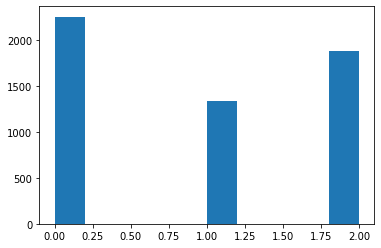

In [ ]:
def mapping(y):
    y_ = y > 0.4 + 0.0
    if y_.sum() == 0:
        return 0
    elif y_[0] == 1:
        return 1 if y[0] > y[1] else 2
    elif y_[1] == 1:
        return 2 if y[1] > y[0] else 1

plt.hist(np.array(list(map(mapping, y_train))))

In [ ]:
trainer = Trainer(model, lr=2e-3, epochs=5, optimizer='lbfgs', criterion=nn.BCELoss(reduce=False, reduction='none'), confidence=0.04)
l = trainer.start([X_train], [y_train[None, ...]], [X_val], [y_val[None, ...]])

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch: 0/5............. Avg. Loss: 0.7468 Avg. accuracy: 0.8928, Avg. Val_Loss: 0.5044 Avg. accuracy: 0.9055
Epoch: 1/5............. Avg. Loss: 0.7333 Avg. accuracy: 0.8949, Avg. Val_Loss: 0.5020 Avg. accuracy: 0.9074
Epoch: 2/5............. Avg. Loss: 0.5575 Avg. accuracy: 0.9397, Avg. Val_Loss: 0.4867 Avg. accuracy: 0.9145
Epoch: 3/5............. Avg. Loss: 0.5245 Avg. accuracy: 0.9394, Avg. Val_Loss: 0.4840 Avg. accuracy: 0.9119
Epoch: 4/5............. Avg. Loss: 0.4598 Avg. accuracy: 0.9381, Avg. Val_Loss: 0.4981 Avg. accuracy: 0.8997


In [ ]:
import pickle
i = 3.1
assert not os.path.exists(f'model{i}.pth'), "Choose unique name"

trainer1 = vars(trainer)
torch.save(model.state_dict(), f'model{i}.pth')
pickle.dump(trainer1, open(f'trainer{i}.pkl', 'wb'))

In [ ]:
!zip models *.pth
!zip trainers *.pkl

  adding: model1.pth (deflated 30%)
  adding: model2.pth (deflated 30%)
  adding: model3.1.pth (deflated 30%)
  adding: model3.pth (deflated 30%)
  adding: trainer1.pkl (deflated 29%)
  adding: trainer2.pkl (deflated 29%)
  adding: trainer3.1.pkl (deflated 30%)
  adding: trainer3.pkl (deflated 29%)


In [ ]:
 for f in glob.glob('trainer*.pkl'):
    t = pickle.load(open(f, 'rb'))
    t['model'] = None
    t['optimizer'] = None
    t['criterion'] = None
    t['output'] = None
    pickle.dump(t, open(f'_{f}', 'wb'))

In [ ]:
!zip _trainers _*.pkl

  adding: _trainer1.pkl (deflated 63%)
  adding: _trainer2.pkl (deflated 63%)
  adding: _trainer3.1.pkl (deflated 52%)
  adding: _trainer3.pkl (deflated 57%)
